In [56]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [57]:
train_dir = "cats_and_dogs_filtered/train"
validation_dir = "cats_and_dogs_filtered/validation"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)                                                            

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


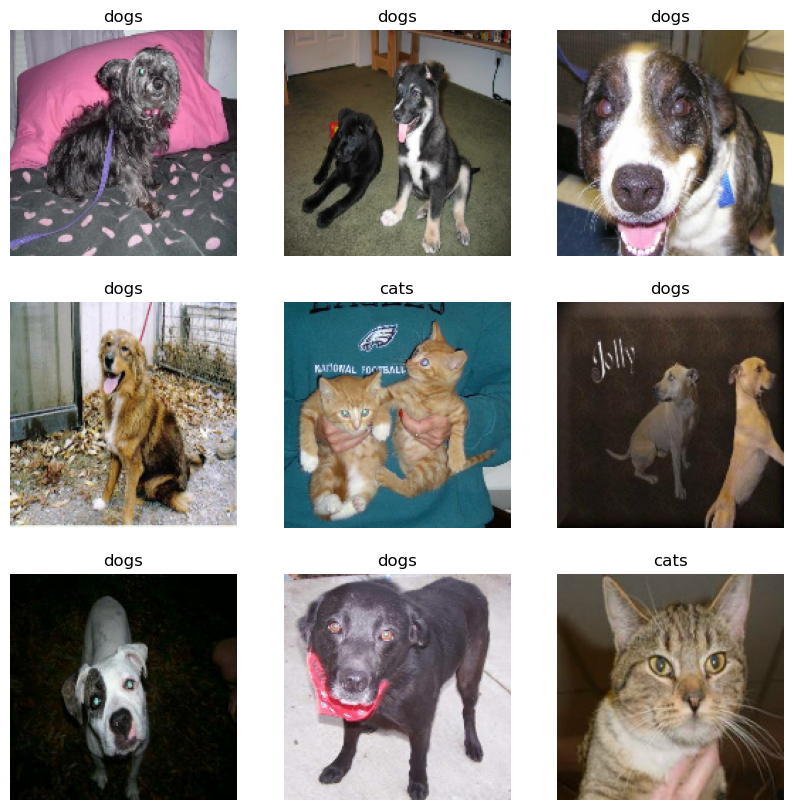

In [58]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [85]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [86]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 21
Number of test batches: 5


In [87]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [88]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

In [89]:
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [90]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1024)


In [91]:
base_model.trainable = False

In [92]:
base_model.summary()

Model: "mobilenet_1.00_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 80, 80, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 80, 80, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 80, 80, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 80, 80, 32)       128       
 ation)                                         

In [93]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


In [94]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [102]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [103]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [104]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 mobilenet_1.00_160 (Functio  (None, 5, 5, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,229,889
Trainable params: 1,025
Non-trainab

In [109]:
len(model.trainable_variables)

2

In [110]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

21/21 [==============================] - 6s 264ms/step - loss: 5.6109e-08 - accuracy: 0.5586


In [111]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.00
initial accuracy: 0.56


In [112]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    )

Epoch 1/10
63/63 [==============================] - 25s 398ms/step - loss: 5.9605e-08 - accuracy: 0.5395 - val_loss: 5.7397e-08 - val_accuracy: 0.5355
Epoch 2/10
63/63 [==============================] - 24s 385ms/step - loss: 5.9605e-08 - accuracy: 0.5295 - val_loss: 5.7949e-08 - val_accuracy: 0.5262
Epoch 3/10
31/63 [=============>................] - ETA: 9s - loss: 6.0085e-08 - accuracy: 0.5323

KeyboardInterrupt: 

In [80]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_160 (Functio  (None, 5, 5, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                  

In [82]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 292ms/step - loss: 0.1759 - accuracy: 0.9323
Test accuracy : 0.9322916865348816


In [84]:
model.save('models/model_3/model.h5')

In [ ]:
# tensorflowjs_converter --input_format=keras .\models\model_3\model.h5 .\models\model_3\build